# 02 - ETL: Límites Parroquiales (CONALI)

**Objetivo:** Procesar y limpiar el shapefile de parroquias para crear la tabla base del análisis

**Entradas:**
- Shapefile CONALI: `LIMITE_PARROQUIAL_CONALI_CNE_2022.shp`

**Salidas:**
- CSV: `parroquias_base.csv` (tabla con atributos + centroides)
- GeoJSON: `parroquias.geojson` (geometrías completas)
- GeoJSON: `parroquias_centroides.geojson` (puntos centrales)

---

## 1. Setup e Imports

In [2]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Rutas
BASE_DIR = Path('../data')
RAW_DIR = BASE_DIR / 'raw' / 'conali_limites'
PROCESSED_DIR = BASE_DIR / 'processed'
GEO_DIR = BASE_DIR / 'geo'

# Crear directorios si no existen
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
GEO_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Librerías cargadas")
print(f"📁 Directorio de entrada: {RAW_DIR}")
print(f"📁 Directorio de salida (processed): {PROCESSED_DIR}")
print(f"📁 Directorio de salida (geo): {GEO_DIR}")

✅ Librerías cargadas
📁 Directorio de entrada: ../data/raw/conali_limites
📁 Directorio de salida (processed): ../data/processed
📁 Directorio de salida (geo): ../data/geo


---
## 2. Cargar Shapefile de Parroquias

In [3]:
# Cargar shapefile
shp_file = RAW_DIR / 'LIMITE_PARROQUIAL_CONALI_CNE_2022.shp'

print(f"📂 Cargando: {shp_file.name}")
parroquias = gpd.read_file(shp_file)

print(f"\n✅ Shapefile cargado exitosamente")
print(f"📊 Dimensiones: {parroquias.shape}")
print(f"🗺️ Sistema de coordenadas: {parroquias.crs}")
print(f"📐 Tipo de geometría: {parroquias.geometry.geom_type.unique()}")

📂 Cargando: LIMITE_PARROQUIAL_CONALI_CNE_2022.shp

✅ Shapefile cargado exitosamente
📊 Dimensiones: (1236, 11)
🗺️ Sistema de coordenadas: EPSG:32717
📐 Tipo de geometría: ['Polygon' 'MultiPolygon']


---
## 3. Explorar Estructura y Atributos

In [4]:
# Ver columnas disponibles
print("📋 COLUMNAS DISPONIBLES:")
for i, col in enumerate(parroquias.columns):
    print(f"  [{i}] {col}")

print(f"\n🔍 PRIMERAS 5 FILAS:")
parroquias.head()

📋 COLUMNAS DISPONIBLES:
  [0] OBJECTID
  [1] CODPRO
  [2] PROVINCIA
  [3] CODCAN
  [4] CANTON
  [5] CODPAR
  [6] PARROQUIA
  [7] ESTADO
  [8] Shape_Leng
  [9] Shape_Area
  [10] geometry

🔍 PRIMERAS 5 FILAS:


,OBJECTID,CODPRO,PROVINCIA,CODCAN,CANTON,CODPAR,PARROQUIA,ESTADO,Shape_Leng,Shape_Area,geometry
0,1,01,AZUAY,260,CUENCA,0285,BAÑOS,RURAL,117974.447808,2.514430e+08,"POLYGON ((714383.483 9679807.792, 714390.309 9..."
1,2,01,AZUAY,260,CUENCA,0730,CUMBE,RURAL,49295.451784,7.513010e+07,"POLYGON ((719475.594 9663878.887, 719478.891 9..."
2,3,01,AZUAY,260,CUENCA,0845,CHAUCHA / ANGAS,RURAL,126245.848716,3.799964e+08,"POLYGON ((685768.602 9685990.681, 685768.699 9..."
3,4,01,AZUAY,260,CUENCA,0860,CHECA JIDCAY,RURAL,70248.163641,1.108570e+08,"POLYGON ((716308.838 9708269.142, 718521.46 97..."
4,5,01,AZUAY,260,CUENCA,0905,CHIQUINTAD,RURAL,65117.093332,9.344493e+07,"POLYGON ((707356.613 9699843.982, 707357.332 9..."


In [5]:
# Información general
print("📊 INFORMACIÓN DEL DATASET:")
parroquias.info()

📊 INFORMACIÓN DEL DATASET:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    1236 non-null   int64   
 1   CODPRO      1236 non-null   object  
 2   PROVINCIA   1236 non-null   object  
 3   CODCAN      1236 non-null   int32   
 4   CANTON      1236 non-null   object  
 5   CODPAR      1236 non-null   object  
 6   PARROQUIA   1236 non-null   object  
 7   ESTADO      1235 non-null   object  
 8   Shape_Leng  1236 non-null   float64 
 9   Shape_Area  1236 non-null   float64 
 10  geometry    1236 non-null   geometry
dtypes: float64(2), geometry(1), int32(1), int64(1), object(6)
memory usage: 101.5+ KB


In [6]:
# Verificar valores nulos
print("⚠️ VALORES NULOS POR COLUMNA:")
nulos = parroquias.isnull().sum()
print(nulos[nulos > 0])

if nulos.sum() == 0:
    print("✅ No hay valores nulos")

⚠️ VALORES NULOS POR COLUMNA:
ESTADO    1
dtype: int64


In [7]:
# Verificar duplicados
duplicados = parroquias.duplicated().sum()
print(f"🔍 DUPLICADOS: {duplicados}")

if duplicados == 0:
    print("✅ No hay registros duplicados")
else:
    print(f"⚠️ Se encontraron {duplicados} registros duplicados")

🔍 DUPLICADOS: 0
✅ No hay registros duplicados


---
## 4. Identificar y Seleccionar Columnas Clave

Necesitamos identificar qué columnas contienen:
- Código o ID de parroquia
- Nombre de parroquia
- Nombre de cantón
- Nombre de provincia
- Códigos DPA (División Político-Administrativa)

In [8]:
# Ver valores únicos de cada columna (excepto geometry)
print("🔍 EXPLORANDO CONTENIDO DE COLUMNAS:")
print("\n(Mostrando primeros 5 valores únicos de cada columna)\n")

for col in parroquias.columns:
    if col != 'geometry':
        valores_unicos = parroquias[col].nunique()
        ejemplos = parroquias[col].dropna().unique()[:5]
        print(f"📌 {col}:")
        print(f"   Valores únicos: {valores_unicos}")
        print(f"   Ejemplos: {ejemplos}")
        print()

🔍 EXPLORANDO CONTENIDO DE COLUMNAS:

(Mostrando primeros 5 valores únicos de cada columna)

📌 OBJECTID:
   Valores únicos: 1236
   Ejemplos: [1 2 3 4 5]

📌 CODPRO:
   Valores únicos: 25
   Ejemplos: ['01' '03' '05' '06' '07']

📌 PROVINCIA:
   Valores únicos: 25
   Ejemplos: ['AZUAY' 'CAÑAR' 'COTOPAXI' 'CHIMBORAZO' 'EL ORO']

📌 CODCAN:
   Valores únicos: 222
   Ejemplos: [260 270 265 885 275]

📌 CANTON:
   Valores únicos: 221
   Ejemplos: ['CUENCA' 'GIRON' 'GUALACEO' 'NABON' 'PAUTE']

📌 CODPAR:
   Valores únicos: 1236
   Ejemplos: ['0285' '0730' '0845' '0860' '0905']

📌 PARROQUIA:
   Valores únicos: 1081
   Ejemplos: ['BAÑOS' 'CUMBE' 'CHAUCHA / ANGAS' 'CHECA JIDCAY' 'CHIQUINTAD']

📌 ESTADO:
   Valores únicos: 2
   Ejemplos: ['RURAL' 'URBANA']

📌 Shape_Leng:
   Valores únicos: 1236
   Ejemplos: [117974.447808   49295.4517836 126245.848716   70248.1636413
  65117.0933323]

📌 Shape_Area:
   Valores únicos: 1236
   Ejemplos: [2.51443021e+08 7.51301043e+07 3.79996370e+08 1.10856972e+08
 9.34

In [9]:
# TODO: Basándose en la exploración anterior, identificar las columnas correctas
# y ajustar este mapeo:

# IMPORTANTE: Ajusta estos nombres según las columnas reales del shapefile
columnas_mapping = {
    'CODPAR': 'codigo_dpa',      # Código DPA de parroquia (ajustar nombre)
    'PARROQUIA': 'nombre_parroquia', # Nombre de parroquia (ajustar nombre)
    'CANTON': 'nombre_canton',    # Nombre de cantón (ajustar nombre)
    'PROVINCIA': 'nombre_provincia', # Nombre de provincia (ajustar nombre)
    'geometry': 'geometry'
}

print("⚠️ ATENCIÓN: Verifica y ajusta el mapeo de columnas según la exploración anterior")
print("\nMapeo propuesto:")
for old, new in columnas_mapping.items():
    print(f"  {old} → {new}")

⚠️ ATENCIÓN: Verifica y ajusta el mapeo de columnas según la exploración anterior

Mapeo propuesto:
  CODPAR → codigo_dpa
  PARROQUIA → nombre_parroquia
  CANTON → nombre_canton
  PROVINCIA → nombre_provincia
  geometry → geometry


In [10]:
# Seleccionar y renombrar columnas
# AJUSTA LAS COLUMNAS EN EL MAPPING ANTES DE EJECUTAR ESTA CELDA

try:
    parroquias_clean = parroquias[list(columnas_mapping.keys())].copy()
    parroquias_clean.rename(columns=columnas_mapping, inplace=True)
    
    print("✅ Columnas seleccionadas y renombradas:")
    print(parroquias_clean.columns.tolist())
    print(f"\n📊 Muestra de datos:")
    print(parroquias_clean.head())
    
except KeyError as e:
    print(f"❌ ERROR: Columna no encontrada: {e}")
    print("\n⚠️ Ajusta el diccionario 'columnas_mapping' con los nombres correctos")

✅ Columnas seleccionadas y renombradas:
['codigo_dpa', 'nombre_parroquia', 'nombre_canton', 'nombre_provincia', 'geometry']

📊 Muestra de datos:
  codigo_dpa nombre_parroquia nombre_canton nombre_provincia  \
0       0285            BAÑOS        CUENCA            AZUAY   
1       0730            CUMBE        CUENCA            AZUAY   
2       0845  CHAUCHA / ANGAS        CUENCA            AZUAY   
3       0860     CHECA JIDCAY        CUENCA            AZUAY   
4       0905       CHIQUINTAD        CUENCA            AZUAY   

                                            geometry  
0  POLYGON ((714383.483 9679807.792, 714390.309 9...  
1  POLYGON ((719475.594 9663878.887, 719478.891 9...  
2  POLYGON ((685768.602 9685990.681, 685768.699 9...  
3  POLYGON ((716308.838 9708269.142, 718521.46 97...  
4  POLYGON ((707356.613 9699843.982, 707357.332 9...  


---
## 5. Limpiar y Estandarizar Nombres

In [11]:
# Función para limpiar nombres
def limpiar_texto(texto):
    """
    Limpia y estandariza nombres geográficos:
    - Convierte a mayúsculas
    - Elimina espacios extra
    - Remueve caracteres especiales innecesarios
    """
    if pd.isna(texto):
        return texto
    
    texto = str(texto)
    texto = texto.strip()  # Eliminar espacios al inicio y final
    texto = texto.upper()  # Convertir a mayúsculas
    texto = ' '.join(texto.split())  # Eliminar espacios múltiples
    
    return texto

# Aplicar limpieza a nombres
print("🧹 LIMPIANDO NOMBRES...")

parroquias_clean['nombre_parroquia'] = parroquias_clean['nombre_parroquia'].apply(limpiar_texto)
parroquias_clean['nombre_canton'] = parroquias_clean['nombre_canton'].apply(limpiar_texto)
parroquias_clean['nombre_provincia'] = parroquias_clean['nombre_provincia'].apply(limpiar_texto)

print("✅ Nombres limpiados")
print(f"\n📊 Muestra:")
print(parroquias_clean[['nombre_provincia', 'nombre_canton', 'nombre_parroquia']].head(10))

🧹 LIMPIANDO NOMBRES...
✅ Nombres limpiados

📊 Muestra:
  nombre_provincia nombre_canton          nombre_parroquia
0            AZUAY        CUENCA                     BAÑOS
1            AZUAY        CUENCA                     CUMBE
2            AZUAY        CUENCA           CHAUCHA / ANGAS
3            AZUAY        CUENCA              CHECA JIDCAY
4            AZUAY        CUENCA                CHIQUINTAD
5            AZUAY        CUENCA                    LLACAO
6            AZUAY        CUENCA                 MOLLETURO
7            AZUAY        CUENCA             MULTI / NULTI
8            AZUAY        CUENCA  OCTAVIO CORDERO PALACIOS
9            AZUAY        CUENCA                    PACCHA


In [12]:
# Verificar provincias únicas
print("🗺️ PROVINCIAS ÚNICAS:")
provincias = sorted(parroquias_clean['nombre_provincia'].unique())
for i, prov in enumerate(provincias, 1):
    count = (parroquias_clean['nombre_provincia'] == prov).sum()
    print(f"  {i:2d}. {prov:20s} - {count:3d} parroquias")

print(f"\n📊 Total: {len(provincias)} provincias")

🗺️ PROVINCIAS ÚNICAS:
   1. AZUAY                -  90 parroquias
   2. BOLIVAR              -  29 parroquias
   3. CARCHI               -  35 parroquias
   4. CAÑAR                -  36 parroquias
   5. CHIMBORAZO           -  61 parroquias
   6. COTOPAXI             -  46 parroquias
   7. EL ORO               -  84 parroquias
   8. ESMERALDAS           -  68 parroquias
   9. GALAPAGOS            -   8 parroquias
  10. GUAYAS               -  77 parroquias
  11. IMBABURA             -  49 parroquias
  12. ISLA                 -   1 parroquias
  13. LOJA                 - 104 parroquias
  14. LOS RIOS             -  42 parroquias
  15. MANABI               - 100 parroquias
  16. MORONA SANTIAGO      -  59 parroquias
  17. NAPO                 -  25 parroquias
  18. ORELLANA             -  33 parroquias
  19. PASTAZA              -  21 parroquias
  20. PICHINCHA            -  96 parroquias
  21. SANTA ELENA          -  16 parroquias
  22. STO DGO TSACHILAS    -  18 parroquias
  23. SUCU

---
## 6. Convertir Sistema de Coordenadas

**Sistema actual:** EPSG:32717 (UTM Zona 17S)  
**Sistema objetivo:** EPSG:4326 (WGS84 - lat/lon)

**Razón:** Mayor compatibilidad con herramientas web y análisis estándar

In [13]:
# Convertir a WGS84
print(f"🔄 CONVERSIÓN DE SISTEMA DE COORDENADAS")
print(f"Desde: {parroquias_clean.crs}")

parroquias_clean = parroquias_clean.to_crs(epsg=4326)

print(f"Hacia: {parroquias_clean.crs}")
print("✅ Conversión completada")

🔄 CONVERSIÓN DE SISTEMA DE COORDENADAS
Desde: EPSG:32717
Hacia: EPSG:4326
✅ Conversión completada


---
## 7. Calcular Centroides

Los centroides serán usados para:
- Geocodificar establecimientos de salud
- Cálculos de distancia
- Visualizaciones de puntos

In [14]:
# Calcular centroides
print("📍 CALCULANDO CENTROIDES...")

# Calcular centroide de cada polígono
parroquias_clean['centroide'] = parroquias_clean.geometry.centroid

# Extraer coordenadas lat/lon del centroide
parroquias_clean['centroide_lon'] = parroquias_clean['centroide'].x
parroquias_clean['centroide_lat'] = parroquias_clean['centroide'].y

print("✅ Centroides calculados")
print(f"\n📊 Ejemplo de coordenadas:")
print(parroquias_clean[['nombre_parroquia', 'centroide_lon', 'centroide_lat']].head(10))

📍 CALCULANDO CENTROIDES...
✅ Centroides calculados

📊 Ejemplo de coordenadas:
           nombre_parroquia  centroide_lon  centroide_lat
0                     BAÑOS     -79.203461      -2.983540
1                     CUMBE     -79.020161      -3.102251
2           CHAUCHA / ANGAS     -79.394565      -2.930624
3              CHECA JIDCAY     -79.041224      -2.711074
4                CHIQUINTAD     -79.056685      -2.769097
5                    LLACAO     -78.930305      -2.841989
6                 MOLLETURO     -79.400478      -2.741101
7             MULTI / NULTI     -78.890328      -2.863917
8  OCTAVIO CORDERO PALACIOS     -78.971054      -2.775596
9                    PACCHA     -78.928937      -2.898646


In [15]:
# Calcular área de cada parroquia (en km²)
print("📐 CALCULANDO ÁREAS...")

# Nota: Para cálculo preciso de área, usar proyección UTM
parroquias_utm = parroquias_clean.to_crs(epsg=32717)
parroquias_clean['area_km2'] = (parroquias_utm.geometry.area / 1_000_000).round(2)

print("✅ Áreas calculadas")
print(f"\n📊 Estadísticas de área (km²):")
print(parroquias_clean['area_km2'].describe())

print(f"\n🔝 TOP 5 PARROQUIAS MÁS GRANDES:")
print(parroquias_clean.nlargest(5, 'area_km2')[['nombre_provincia', 'nombre_parroquia', 'area_km2']])

📐 CALCULANDO ÁREAS...
✅ Áreas calculadas

📊 Estadísticas de área (km²):
count    1236.000000
mean      208.102888
std       508.167433
min         0.390000
25%        31.090000
50%        91.840000
75%       219.062500
max      8220.170000
Name: area_km2, dtype: float64

🔝 TOP 5 PARROQUIAS MÁS GRANDES:
    nombre_provincia   nombre_parroquia  area_km2
445          PASTAZA            CURARAY   8220.17
432          PASTAZA  MONTALVO / ANDOAS   7949.04
502         ORELLANA           CONONACO   7124.36
435          PASTAZA          RIO TIGRE   5643.07
901        GALAPAGOS  TOMAS DE BERLANGA   5526.37


---
## 8. Crear Tabla Base

Tabla final con todos los atributos necesarios para análisis posteriores

In [16]:
# Crear tabla base (sin geometría)
tabla_base = parroquias_clean.drop(columns=['geometry', 'centroide']).copy()

print("📋 TABLA BASE CREADA")
print(f"Dimensiones: {tabla_base.shape}")
print(f"\nColumnas:")
print(tabla_base.columns.tolist())
print(f"\n📊 Primeras filas:")
print(tabla_base.head())

📋 TABLA BASE CREADA
Dimensiones: (1236, 7)

Columnas:
['codigo_dpa', 'nombre_parroquia', 'nombre_canton', 'nombre_provincia', 'centroide_lon', 'centroide_lat', 'area_km2']

📊 Primeras filas:
  codigo_dpa nombre_parroquia nombre_canton nombre_provincia  centroide_lon  \
0       0285            BAÑOS        CUENCA            AZUAY     -79.203461   
1       0730            CUMBE        CUENCA            AZUAY     -79.020161   
2       0845  CHAUCHA / ANGAS        CUENCA            AZUAY     -79.394565   
3       0860     CHECA JIDCAY        CUENCA            AZUAY     -79.041224   
4       0905       CHIQUINTAD        CUENCA            AZUAY     -79.056685   

   centroide_lat  area_km2  
0      -2.983540    251.44  
1      -3.102251     75.13  
2      -2.930624    380.00  
3      -2.711074    110.86  
4      -2.769097     93.44  


In [17]:
# Crear GeoDataFrame solo con centroides
parroquias_centroides = gpd.GeoDataFrame(
    tabla_base.copy(),
    geometry=parroquias_clean['centroide'].values,
    crs='EPSG:4326'
)

print("📍 GEODATAFRAME DE CENTROIDES CREADO")
print(f"Dimensiones: {parroquias_centroides.shape}")
print(f"Sistema de coordenadas: {parroquias_centroides.crs}")

📍 GEODATAFRAME DE CENTROIDES CREADO
Dimensiones: (1236, 8)
Sistema de coordenadas: EPSG:4326


---
## 9. Validaciones Finales

In [18]:
# Validaciones
print("✅ VALIDACIONES FINALES\n")

# 1. Sin valores nulos en columnas clave
columnas_clave = ['codigo_dpa', 'nombre_parroquia', 'nombre_canton', 'nombre_provincia']
nulos_clave = tabla_base[columnas_clave].isnull().sum()

if nulos_clave.sum() == 0:
    print("✅ 1. No hay valores nulos en columnas clave")
else:
    print("⚠️ 1. ADVERTENCIA: Valores nulos encontrados:")
    print(nulos_clave[nulos_clave > 0])

# 2. Códigos DPA únicos
codigos_duplicados = tabla_base['codigo_dpa'].duplicated().sum()
if codigos_duplicados == 0:
    print("✅ 2. Todos los códigos DPA son únicos")
else:
    print(f"⚠️ 2. ADVERTENCIA: {codigos_duplicados} códigos DPA duplicados")

# 3. Centroides dentro de Ecuador (validación simple)
lat_validas = tabla_base['centroide_lat'].between(-5, 2).all()
lon_validas = tabla_base['centroide_lon'].between(-92, -75).all()

if lat_validas and lon_validas:
    print("✅ 3. Coordenadas de centroides válidas")
else:
    print("⚠️ 3. ADVERTENCIA: Algunas coordenadas fuera del rango esperado")

# 4. Áreas positivas
areas_positivas = (tabla_base['area_km2'] > 0).all()
if areas_positivas:
    print("✅ 4. Todas las áreas son positivas")
else:
    print("⚠️ 4. ADVERTENCIA: Algunas áreas son cero o negativas")

# 5. Total de parroquias
print(f"\n📊 RESUMEN:")
print(f"Total de parroquias procesadas: {len(tabla_base)}")
print(f"Total de provincias: {tabla_base['nombre_provincia'].nunique()}")
print(f"Total de cantones: {tabla_base['nombre_canton'].nunique()}")

✅ VALIDACIONES FINALES

✅ 1. No hay valores nulos en columnas clave
✅ 2. Todos los códigos DPA son únicos
✅ 3. Coordenadas de centroides válidas
✅ 4. Todas las áreas son positivas

📊 RESUMEN:
Total de parroquias procesadas: 1236
Total de provincias: 25
Total de cantones: 221


---
## 10. Exportar Datos Limpios

In [19]:
# 1. Exportar tabla base (CSV)
csv_output = PROCESSED_DIR / 'parroquias_base.csv'
tabla_base.to_csv(csv_output, index=False, encoding='utf-8')
print(f"✅ 1. CSV exportado: {csv_output.name}")

# 2. Exportar polígonos completos (GeoJSON)
geojson_poligonos = GEO_DIR / 'parroquias.geojson'
parroquias_clean.drop(columns=['centroide']).to_file(geojson_poligonos, driver='GeoJSON')
print(f"✅ 2. GeoJSON (polígonos) exportado: {geojson_poligonos.name}")

# 3. Exportar centroides (GeoJSON)
geojson_centroides = GEO_DIR / 'parroquias_centroides.geojson'
parroquias_centroides.to_file(geojson_centroides, driver='GeoJSON')
print(f"✅ 3. GeoJSON (centroides) exportado: {geojson_centroides.name}")

print("\n" + "="*70)
print("🎉 EXPORTACIÓN COMPLETADA")
print("="*70)
print(f"\n📂 Archivos generados:")
print(f"  • {csv_output}")
print(f"  • {geojson_poligonos}")
print(f"  • {geojson_centroides}")

✅ 1. CSV exportado: parroquias_base.csv
✅ 2. GeoJSON (polígonos) exportado: parroquias.geojson
✅ 3. GeoJSON (centroides) exportado: parroquias_centroides.geojson

🎉 EXPORTACIÓN COMPLETADA

📂 Archivos generados:
  • ../data/processed/parroquias_base.csv
  • ../data/geo/parroquias.geojson
  • ../data/geo/parroquias_centroides.geojson


---
## 11. Visualización Final

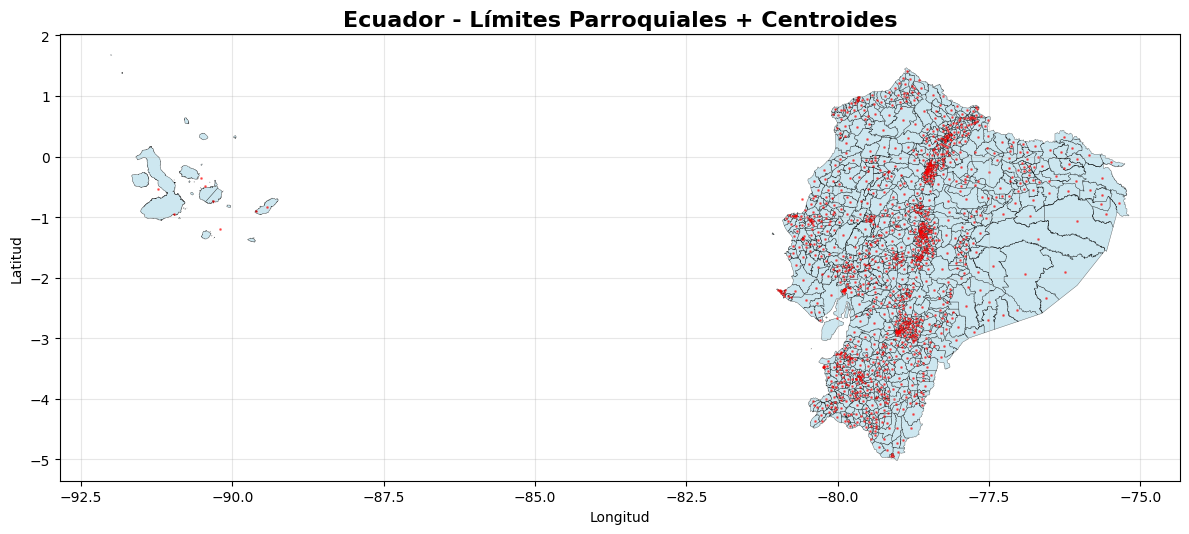

✅ Mapa generado con 1236 parroquias


In [20]:
import matplotlib.pyplot as plt

# Mapa simple de verificación
fig, ax = plt.subplots(figsize=(12, 14))

# Polígonos de parroquias
parroquias_clean.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, alpha=0.6)

# Centroides
parroquias_centroides.plot(ax=ax, color='red', markersize=1, alpha=0.5)

ax.set_title('Ecuador - Límites Parroquiales + Centroides', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Mapa generado con {len(parroquias_clean)} parroquias")